In [1031]:
import pandas as pd
import numpy as np
import networkx as nx
import operator as op
import itertools
import matplotlib.pyplot as plt
import numpy.linalg
import cmath
import multiprocessing
import itertools
import scipy.optimize as optimize
from tabulate import tabulate
from documentCentrality import document_centrality
%matplotlib inline

In [624]:
def pr_df(df):
  print(tabulate(df, headers='keys', tablefmt="fancy_grid"))

In [40]:
#Dummy Data set
dummy=pd.DataFrame([['t', 'c', 1988],
                    ['c', 'g', 1989],
                    ['a', 'c', 1989],
                    ['g', 'a', 1990],
                    ['a', 't', 1991],
                    ['t', 'l', 1992],
                    ['a', 'b', 1993],
                    ['c', 'b', 1993],
                    ['g', 'k', 1994],
                    ['p', 'k', 1994],
                    ['a', 'c', 1995],
                    ['p', 'c', 1995],
                    ['g', 'c', 1995],
                    ['l', 'n', 1995],
                    ['c', 't', 1995],
                    ['p', 'r', 1996],
                    ['p', 'k', 1996],
                    ['t', 'a', 1996],
                    ['r', 'l', 1997],
                    ['g', 'w', 1997],
                    ['r', 'c', 1998],
                    ['p', 'q', 1998],
                    ['r', 'g', 1998],
                    ['a', 'p', 1999],
                    ['r', 'p', 1998]],columns = ["source_id", "target_id", "timestamp"])    

dummy.source_id = dummy.source_id.astype(str)
dummy.target_id = dummy.target_id.astype(str)
t_min=dummy.timestamp.min()
t_max=dummy.timestamp.max()
N=10
dataset = dummy

In [3]:
def create_intervals(dataset,N):


    t_min=dataset.timestamp.min()
    t_max=dataset.timestamp.max()


    dt=(t_max-t_min)/N
    
    intervals=[]
    for j in range(0,N):

        #Start of time interval
        tj=t_min + j*dt
        
        #End of time interval
        tj1=t_min +(j+1)*dt

        intervals.append([int(tj),int(tj1)])

    return(intervals)

In [4]:
class graph(object):
    def __init__(self,dataset, t0,t1):
        self.t0 = t0
        self.t1 = t1
        self.dataset = dataset
        self.create_graph()
        self.interval=[t0,t1]
        
    def create_graph(self):
        self.batch = self.create_batch()
        self.graph = nx.from_pandas_edgelist(self.batch, 'source_id', 'target_id')
        

    def create_batch(self):
        
        df_indexes=[]
        index = 0
        self.dataset = self.dataset.reset_index(drop=True)
            
        if self.t1 == self.dataset.timestamp.max():
            while index < len(self.dataset)and self.dataset.timestamp[index]<=self.t1 :
                if self.dataset.timestamp[index]>=self.t0:
                    df_indexes.append(index)
                    
                index = index +1

            batch = self.dataset.iloc[df_indexes]

            return(batch)

        else:
            while index < len(self.dataset)and self.dataset.timestamp[index]<self.t1 :
                if self.dataset.timestamp[index]>=self.t0:
                    df_indexes.append(index)
                    
                index = index +1

            batch = self.dataset.iloc[df_indexes]
            
            return(batch)

In [5]:
def vertices_intersection(dataset,t0,t1,t2):
    
    #Create two graphs
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1=set(G1.graph.nodes())
    S2=set(G2.graph.nodes())
    #print(S1,S2)
    return set.intersection(S1,S2) #Return the common nodes

In [148]:
def E_prev_set(dataset,t0,t1,t2):
    
    #Calculate the intersection
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1 = set(G1.graph.nodes())
    S2 = set(G2.graph.nodes())
    
    intersection = set.intersection(S1,S2)
    #Calculate the the intersection vertices in [t-1, t)
    df = pd.DataFrame(columns = ["source_id", "target_id", "timestamp"])
    for row in G1.batch.itertuples():
        if (row.source_id in intersection and row.target_id in intersection) and (t0<=row.timestamp<t1):
            #print(row.target_id,row.source_id)
            df = pd.concat([df,pd.DataFrame([row])],axis = 0)

    if not df.empty:
        del df['Index']
        df=df.reset_index(drop=True)

        #Calculate the intersection edges in [t-1, t)
        G= graph(df,t0,t1)

        return set(G.graph.edges())

In [149]:
def E_next_set(dataset,t0,t1,t2):
    
    #Calculate the intersection
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1 = set(G1.graph.nodes())
    S2 = set(G2.graph.nodes())
    
    intersection = set.intersection(S1,S2)

    #Calculate the the intersection vertices in [t, t+1)
    df = pd.DataFrame(columns = ["source_id", "target_id", "timestamp"])
    for row in G2.batch.itertuples():
        if (row.source_id in intersection and row.target_id in intersection) and (t1<=row.timestamp<t2):
            df = pd.concat([df,pd.DataFrame([row])],axis = 0)
    
    if not df.empty:
        del df['Index']
        df=df.reset_index(drop=True)

        #Calculate the intersection edges in [t, t+1)
        G= graph(df,t1,t2)

        return set(G.graph.edges())

In [150]:
def vertices_volume(dataset,N):
    
    time_intervals = create_intervals(dataset,N)
    #print(time_intervals)
    intersection_list=[]
    i = 0
    for time_interval in time_intervals:
        if i < (len(time_intervals)-1):
            dt = time_interval[1] - time_interval[0]
            intersection_list.append(len(vertices_intersection(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)))
    #print(vertices_intersection(dataset, 1994, 1996, 1998))
        
    return(intersection_list)

In [151]:
def jaccard_distance(dataset,t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set = E_prev_set(dataset,t0,t1,t2)

    #Create the graph Object
    Gprev=nx.Graph()
    
    #Add the common vertices for the [t-1, t+1]
    Gprev.add_nodes_from(vertices_list)
    #Take the edges of the [t-1, t) interval
    if edges_set is not None:
        Gprev.add_edges_from(edges_set)
    
    pos = nx.spring_layout(Gprev)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(Gprev, pos, node_size=700)
    # edges
    nx.draw_networkx_edges(Gprev, pos, edgelist=edges_set,
                           width=6)
    # labels
    nx.draw_networkx_labels(Gprev, pos, font_size=20, font_family='sans-serif')
    plt.axis('off')
    plt.show()
    
    jacc = list(nx.jaccard_coefficient(Gprev))
    df=pd.DataFrame(0,index=vertices_list, columns=vertices_list)
    for i in range(0,len(jacc)):
        df.loc[jacc[i][0],jacc[i][1]] = jacc[i][2]
        df.loc[jacc[i][1],jacc[i][0]] = jacc[i][2]
        
    return(df)

In [152]:
def calculate_label(dataset,t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set_prev = E_prev_set(dataset,t0,t1,t2)
    edges_set_next = E_next_set(dataset,t0,t1,t2)
    label=pd.DataFrame('-',index=vertices_list, columns=vertices_list)
    if edges_set_prev is not None:
        edges_prev=list(edges_set_prev)
        for i in range(0,len(edges_prev)):
            label.loc[edges_prev[i][0],edges_prev[i][1]] = 0
            label.loc[edges_prev[i][1],edges_prev[i][0]] = 0
    if edges_set_next is not None:
        edges_next=list(edges_set_next)
        for i in range(0,len(edges_next)):
            label.loc[edges_next[i][0],edges_next[i][1]] = '+'
            label.loc[edges_next[i][1],edges_next[i][0]] = '+'
    for i in range(0,len(vertices_list)):
        label.loc[vertices_list[i],vertices_list[i]] = 0
    return label

In [153]:
def calculate_jaccard_distance(dataset, N):
    
    time_intervals = create_intervals(dataset,N)
    for time_interval in time_intervals:

        dt = time_interval[1] - time_interval[0]

        #Common Neighbors Distance Calculation
        matrix=jaccard_distance(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        label=calculate_label(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        if (matrix is not None) and (not matrix.empty):
            print(time_interval)
            pretty_df(matrix)
            pretty_df(label)

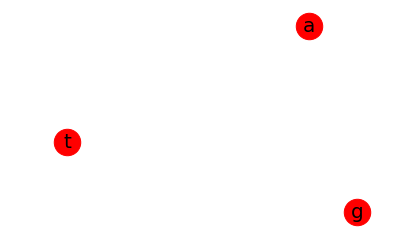

[1988, 1990]
╒════╤═════╤═════╤═════╕
│    │   a │   g │   t │
╞════╪═════╪═════╪═════╡
│ a  │   0 │   0 │   0 │
├────┼─────┼─────┼─────┤
│ g  │   0 │   0 │   0 │
├────┼─────┼─────┼─────┤
│ t  │   0 │   0 │   0 │
╘════╧═════╧═════╧═════╛
╒════╤═════╤═════╤═════╕
│    │ a   │ g   │ t   │
╞════╪═════╪═════╪═════╡
│ a  │ 0   │ +   │ +   │
├────┼─────┼─────┼─────┤
│ g  │ +   │ 0   │ -   │
├────┼─────┼─────┼─────┤
│ t  │ +   │ -   │ 0   │
╘════╧═════╧═════╧═════╛


C:\Users\faisal\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


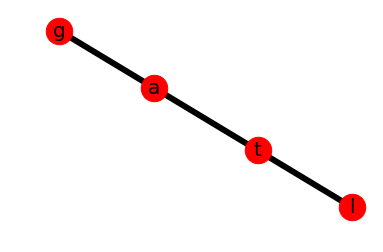

[1990, 1993]
╒════╤═════╤═════╤═════╤═════╕
│    │   a │   g │   l │   t │
╞════╪═════╪═════╪═════╪═════╡
│ a  │ 0   │ 0   │ 0.5 │ 0   │
├────┼─────┼─────┼─────┼─────┤
│ g  │ 0   │ 0   │ 0   │ 0.5 │
├────┼─────┼─────┼─────┼─────┤
│ l  │ 0.5 │ 0   │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┤
│ t  │ 0   │ 0.5 │ 0   │ 0   │
╘════╧═════╧═════╧═════╧═════╛
╒════╤═════╤═════╤═════╤═════╕
│    │ a   │ g   │ l   │ t   │
╞════╪═════╪═════╪═════╪═════╡
│ a  │ 0   │ 0   │ -   │ 0   │
├────┼─────┼─────┼─────┼─────┤
│ g  │ 0   │ 0   │ -   │ -   │
├────┼─────┼─────┼─────┼─────┤
│ l  │ -   │ -   │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┤
│ t  │ 0   │ -   │ 0   │ 0   │
╘════╧═════╧═════╧═════╧═════╛


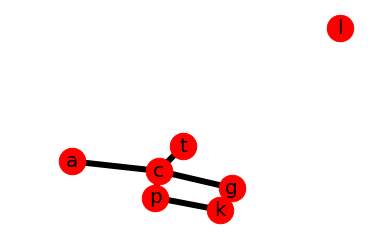

[1993, 1996]
╒════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╕
│    │   a │   c │   g │   k │   l │   p │   t │
╞════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ a  │ 0   │ 0   │ 0.5 │ 0   │   0 │ 0.5 │ 1   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ c  │ 0   │ 0   │ 0   │ 0.5 │   0 │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ g  │ 0.5 │ 0   │ 0   │ 0   │   0 │ 1   │ 0.5 │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ k  │ 0   │ 0.5 │ 0   │ 0   │   0 │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ l  │ 0   │ 0   │ 0   │ 0   │   0 │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ p  │ 0.5 │ 0   │ 1   │ 0   │   0 │ 0   │ 0.5 │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ t  │ 1   │ 0   │ 0.5 │ 0   │   0 │ 0.5 │ 0   │
╘════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╛
╒════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╕
│    │ a   │ c   │ g   │ k   │ l   │ p   │ t   │
╞════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ a  │ 

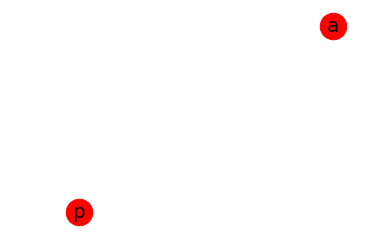

[1996, 1999]
╒════╤═════╤═════╕
│    │   a │   p │
╞════╪═════╪═════╡
│ a  │   0 │   0 │
├────┼─────┼─────┤
│ p  │   0 │   0 │
╘════╧═════╧═════╛
╒════╤═════╤═════╕
│    │ a   │ p   │
╞════╪═════╪═════╡
│ a  │ 0   │ +   │
├────┼─────┼─────┤
│ p  │ +   │ 0   │
╘════╧═════╧═════╛


In [154]:
calculate_jaccard_distance(dataset, 4)

In [155]:
x = np.arange(10)

In [156]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [162]:
x[6]

6

In [3]:
df = pd.read_csv('dataset/apnea-all,3.csv')

In [4]:
df.head()

,art_id,keyword,art_year,citation,title,author_name,affiliation_1,affiliation_2,country
0,101155,tracheostomy,1980,4,Therapeutic Effects of Tracheostomy in Two Cas...,sugita y; wakamatsu h; teshima y; tanaka k; fu...,department of neuropsychiatry osaka universit...,osaka,japan
1,101162,development; gender; respiration,1980,11,Respiration during the first six months of lif...,hoppenbrouwers t; hodgman je; harper rm; sterm...,newborn division the los angeles countyuniver...,ca,united states
2,101167,infant; periodic breathing,1980,4,VENTILATORY STUDIES IN TWO OLDER INFANTS WITH ...,lagercrantz h; broberger u; milerad j; euler cv,department of paediatrics karolinska hospital...,stockholm,sweden
3,101023,hemodynamics; sleep apnea,1981,51,Abnormalities of pulmonary artery wedge pressu...,buda aj; schroeder js; guilleminault c,division of cardiology sleep disorders clinic...,ca,united states
4,101050,hirschprung disease; ondine curse; pulmonary h...,1981,18,TOTAL AGANGLIONOSIS OF THE COLON HIRSCHSPRUNG ...,stern m; hellwege hh; grvinghoff l; lambrecht w,departments of paediatrics and surgery univer...,hamburg,germany


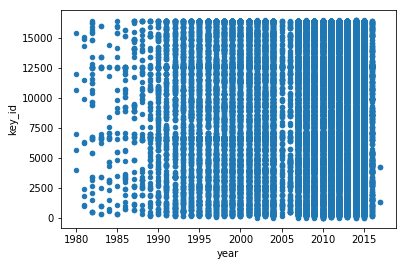

In [28]:
df.plot(kind='scatter', x='year', y='key_id')

In [249]:
sm_df=df[(df['art_year']<1990)]

In [157]:
key_list = pd.read_csv('dataset/apnea-distinct_keyword.csv')

In [158]:
key_list.query('id==50')['keyword'].iloc[0]

'2-arachidonyl-glycerol'

In [250]:
sm_df["keyword"]= sm_df["keyword"].str.split("; ", n = 20, expand = False) 

C:\Users\faisal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [160]:
p=key_list[key_list['keyword']==sm_df["keyword"][2][1]]['id'].iloc[0]

In [161]:
print(p)

10649


In [162]:
sm_df.keyword[4]

['hirschprung disease', 'ondine curse', 'pulmonary hypertension']

In [163]:
gp=nx.MultiGraph()
for index, row in sm_df.iterrows():
    for key in row["keyword"]:
        key_id=key_list[key_list['keyword']==key]['id'].iloc[0]
        gp.add_node(key_id)

In [164]:
edge_list=[]
for index, row in sm_df.iterrows():
    edges=list(itertools.combinations(row["keyword"], 2))
    for edge in edges:
        node1=key_list[key_list['keyword']==edge[0]]['id'].iloc[0]
        node2=key_list[key_list['keyword']==edge[1]]['id'].iloc[0]
        #print(edge[0],edge[1],node1,node2,row["art_id"],row["art_year"])
        edge_list.append((node1,node2))
        gp.add_edge(node1,node2,art_id=row["art_id"],year=row["art_year"])
#print(edge_list)
#gp.add_edges_from(edge_list)

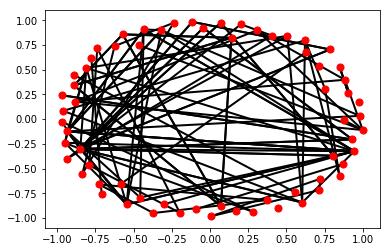

In [165]:
nx.draw_networkx_nodes(gp, pos, node_size=50)
nx.draw_networkx_edges(gp, pos, edgelist=edge_list,width=2)

In [166]:
paths = nx.all_simple_paths(gp, source=3962, target=11948, cutoff=6)
print(list(paths))

[[3962, 5684, 11948], [3962, 11948]]


In [196]:
gp.edges([6716,6539])

MultiEdgeDataView([(6716, 12784), (6716, 2079), (6716, 3392), (6716, 3392), (6716, 6539), (6716, 6539), (6716, 6539), (6716, 10649), (6716, 12542), (6716, 12485), (6716, 6574), (6716, 6651), (6716, 6651), (6716, 2338), (6539, 6574), (6539, 6574), (6539, 15497), (6539, 2079), (6539, 3392), (6539, 3392), (6539, 10649), (6539, 12542), (6539, 6651), (6539, 6651), (6539, 2338)])

In [203]:
for n in gp.edges.data():
    df.head()

In [204]:
[n for n in gp.neighbors(6716)]


[12784, 2079, 3392, 6539, 10649, 12542, 12485, 6574, 6651, 2338]

In [253]:
def keyword_split(df):
    df["keyword"]= df["keyword"].str.split("; ", n = 20, expand = False)  
    return df

In [254]:
def node_key_find(kl,label):
    key=kl[kl['keyword']==label]['id'].iloc[0]
    return key

def node_label_find(kl,key):
    label=kl[kl['id']==key]['keyword'].iloc[0]
    return label    

In [1088]:
def nodes_intersection(df,kl,t0,t1,t2):
    prelist=[]
    postlist=[]
    pre_df=df[(df['art_year']>=t0)&(df['art_year']<t1)]
    post_df=df[(df['art_year']>=t1)&(df['art_year']<t2)]
    for index, row in pre_df.iterrows():
        for label in row["keyword"]:
            node_id=node_key_find(kl,label)
            prelist.append(node_id)
    for index, row in post_df.iterrows():
        for label in row["keyword"]:
            node_id=node_key_find(kl,label)
            postlist.append(node_id)
    return set(prelist).intersection(set(postlist))

In [1089]:
def build_graph(g,df,kl,nodes,t0,t1):
    g_df=df[(df['art_year']>=t0)&(df['art_year']<t1)]
    #node insert
    for index, row in g_df.iterrows():
        for label in row["keyword"]:
            node_id=node_key_find(kl,label)
            if node_id in nodes:
                g.add_node(node_id,art_id=row["art_id"])
    #edge insert
    for index, row in g_df.iterrows():
        edges=list(itertools.combinations(row["keyword"], 2))
        for edge in edges:
            node1=node_key_find(kl,edge[0])
            node2=node_key_find(kl,edge[1])
            if (node1 in nodes) and (node2 in nodes) and (node1!=node2):
                g.add_edge(node1,node2,art_id=row["art_id"],year=row["art_year"])
    return g

In [1156]:
def node_and_article_feature(df,kl,nodes,g,t0,t1):
    f_df=df[(df['art_year']>=t0)&(df['art_year']<t1)]
    article_set= set([article for node,article in g.node(data='art_id')])
    article_index=list(article_set)
    node_index=list(nodes)
    td=np.zeros((len(g.nodes()), len(article_set)))
    for index,row in f_df.iterrows():
        for key in row[1]:
            node_key = node_key_find(kl,key)
            if (row[0] in article_set) and (node_key in nodes):
                td[node_index.index(node_key)][ar_index.index(row[0])]=1
    #document centrality feature 
    ca,cn=document_centrality(td,20)
    node_feature=pd.DataFrame({'node_index':node_index,'term_centrality':cn})
    article_feature=pd.DataFrame({'article_index':ar_index,'article_centrality_on_node':ca})
    return node_feature,article_feature

In [1157]:
def classification_data(df,kl,nodes,g_train,g_test,t0,t1):
    all_node_pairs = set(pair for pair in itertools.combinations(nodes,2))
    all_node_pairs = set((a,b) if a<=b else (b,a) for a,b in all_node_pairs)
    all_train_edges=set(g_train.edges(keys=False))
    all_train_edges = set((a,b) if a<=b else (b,a) for a,b in all_train_edges)
    all_test_edges=set(g_test.edges(keys=False))
    all_test_edges = set((a,b) if a<=b else (b,a) for a,b in all_test_edges)
    train_rows = list(all_node_pairs.difference(all_train_edges))
    train_labels= [1 if row in all_test_edges else 0 for row in train_rows]
    train_data = pd.DataFrame({'row_name':train_rows,'label':train_labels})
    test_data = pd.DataFrame({'row_name':list(all_test_edges)})
    
    #node and article feature
    node_feature,article_feature = node_and_article_feature(df,kl,nodes,g_train,t0,t1)
    return train_data,test_data

In [1158]:
train,test=classification_data(sm_df,key_list,nodes,g_train,g_test,1970,1990)

In [1093]:
df = pd.read_csv('dataset/apnea-all,3.csv')
key_list = pd.read_csv('dataset/apnea-distinct_keyword.csv')
article_keywords = pd.read_csv('dataset/apnea-art_id,keyword,key_id,3.csv')
sm_df=df[(df['art_year']<2000)]
sm_df=keyword_split(sm_df)

C:\Users\faisal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1095]:
nodes=nodes_intersection(sm_df,key_list,1970,1990,2020)
len(nodes)

165

In [1094]:
g=nx.MultiGraph()
g_train=build_graph(g,sm_df,key_list,nodes,1970,1990)
g=nx.MultiGraph()
g_test=build_graph(g,sm_df,key_list,nodes,1990,2000)

In [364]:
print(len(g_train.edges()),len(g_test.edges()),len(g_train.nodes()),len(g_test.nodes()))

282 757 165 165


In [1098]:
train,test=classification_data(sm_df,key_list,nodes,g_train,g_test,1970,1990)

C:\Users\faisal\PycharmProjects\linkPrediction\documentCentrality.py:22: RuntimeWarning: divide by zero encountered in true_divide
  k[:, i] = (1 / k0).transpose() * td.transpose().dot(l[:, i - 1])
C:\Users\faisal\PycharmProjects\linkPrediction\documentCentrality.py:22: RuntimeWarning: invalid value encountered in multiply
  k[:, i] = (1 / k0).transpose() * td.transpose().dot(l[:, i - 1])
C:\Users\faisal\PycharmProjects\linkPrediction\documentCentrality.py:23: RuntimeWarning: divide by zero encountered in true_divide
  l[:, i] = (1 / l0) * td.dot(k[:, i - 1])
C:\Users\faisal\PycharmProjects\linkPrediction\documentCentrality.py:23: RuntimeWarning: invalid value encountered in multiply
  l[:, i] = (1 / l0) * td.dot(k[:, i - 1])
C:\Users\faisal\PycharmProjects\linkPrediction\documentCentrality.py:27: RuntimeWarning: Mean of empty slice
  x1 = (x1 - np.nanmean(x1)) / np.nanstd(x1, ddof=1)
C:\Users\faisal\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of

ValueError: arrays must all be same length

In [531]:
article_id = list(df['art_id'])

In [875]:
article_list=set([weight for u,v,keys,weight in g_train.edges(data='art_id', keys=True)])

In [570]:
len(article_list)
len(g_train.nodes())
ar_
td=np.zeros((len(g_train.nodes()), len(article_list)))
np.shape(td)

(165, 108)

410

In [966]:
article_set= set([article for node,article in g_train.node(data='art_id')])
article_index=list(article_list)
node_index=list(nodes)
td=np.zeros((len(g_train.nodes()), len(article_list)))
np.shape(td)
for node,article in g_train.node(data='art_id'):
    td[node_index.index(node)][article_index.index(article)]=1

In [1008]:
l0 = td.sum(axis=0)
len(article_set.difference(set(nd)))

0

In [1019]:
ar_index=list(article_list)
node_index=list(g_train.nodes())
td=np.zeros((len(node_index), len(ar_index)))
len(node_index)

165

In [1020]:
n=[]
for index,row in article_keywords.iterrows():
    if row['key_id'] in set(nodes) and row['article_id'] in set(ar_index):
        #td[node_index.index(row['key_id'])][ar_index.index(row['article_id'])]=1
        n.append(row['article_id'])
nd=[]
nd1=[]
nd2=[]
for index,row in sm_df[(sm_df['art_year']<1990)].iterrows():
    for key in row[1]:
        if (row[0] in article_set) and (node_key_find(key_list,key) in nodes):
            td[node_index.index(node_key_find(key_list,key))][ar_index.index(row[0])]=1

In [1084]:
def node_and_article_feature(df,kl,nodes,g,t1,t2):
    f_df=df[(df['art_year']>=t1)&(df['art_year']<t2)]
    article_set= set([article for node,article in g.node(data='art_id')])
    article_index=list(article_set)
    node_index=list(nodes)
    td=np.zeros((len(g.nodes()), len(article_set)))
    for index,row in f_df.iterrows():
        for key in row[1]:
            node_key = node_key_find(kl,key)
            if (row[0] in article_set) and (node_key in nodes):
                td[node_index.index(node_key)][ar_index.index(row[0])]=1
    ca,cn=document_centrality(td,20)
    node_feature=pd.DataFrame({'node_index':node_index,'term_centrality':cn})
    article_feature=pd.DataFrame({'article_index':ar_index,'article_centrality_on_node':ca})
    return node_feature,article_feature

In [1085]:
node_and_article_feature(sm_df,key_list,nodes,g_train,1970,1990)

(     node_index  term_centrality
 0         14850         2.399666
 1          3591         1.120377
 2          4623        -1.584315
 3         14867         1.864043
 4          1044        -1.584315
 5          2582         0.813509
 6          9240         0.277603
 7          2079         0.900133
 8          1533        -1.056093
 9         11299         0.791008
 10         5668        -0.745255
 11         2600        -1.584315
 12         6702         1.642629
 13         5167        -1.584315
 14        15920        -1.584315
 15        10801        -1.584315
 16          562        -0.470670
 17         8242        -0.880019
 18         5684         0.153718
 19         6200        -1.584315
 20         6713        -1.584315
 21        14395        -0.431356
 22         6716         5.553398
 23        15421        -1.584315
 24        11841        -1.584315
 25         2626        -0.521676
 26         1091        -1.056101
 27        15944        -1.584315
 28        144

In [844]:
for index, row in pre_df.iterrows():
        edges=list(itertools.combinations(row["keyword"], 2))
        for edge in edges:
            if edge[0] in set(kk) or edge[1] in set(kk):
                s=node_key_find(kl,edge[0])
                t=node_key_find(kl,edge[1])
                #if (s in nodes and t in nodes):
                print(edge,row['art_year'])
list(g_train.neighbors(6200))

('hemodynamics', 'sleep apnea') 1981
('palatopharyngoplasty', 'tracheostomy') 1982
('apnea detection', 'tracheal sound analysis') 1983
('cerebral blood flow', 'hemorheology') 1983
('apnea detection', 'tracheal sound analysis') 1983
('apnea detection', 'tracheal sound analysis') 1983
('electrophysiology', 'reliability') 1984
('measurement error', 'reliability') 1984
('hypersomnia', 'nasal septum deviation') 1985
('focal glomerular sclerosis', 'proteinuria') 1989


[]

In [806]:
kk=[]
for dd in set(ncx).difference(n):
    #print (node_label_find(kl,dd))
    kk.append(node_label_find(kl,dd))


In [807]:
len(kk)

7

In [1045]:
cd,ct=document_centrality(td,20)

In [1047]:
print(len(cd),len(ct))

114 165
